In [1]:
import yfinance as yf 
import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# example 1 
start_date = dt.date(2024,4,1)
end_date = dt.datetime.today().strftime("%Y-%m-%d")

# download dataframe 
data = yf.download(["SPY","QQQ"], start_date, end_date, group_by='ticker')
print(type(data))
print(data)

[*********************100%%**********************]  2 of 2 completed

<class 'pandas.core.frame.DataFrame'>
Ticker             QQQ                                                                   SPY                                                           
Price             Open        High         Low       Close   Adj Close    Volume        Open        High         Low       Close   Adj Close     Volume
Date                                                                                                                                                   
2024-04-01  444.970001  447.529999  443.019989  444.950012  444.950012  38729000  523.830017  524.380005  520.969971  522.159973  522.159973   62477500
2024-04-02  440.079987  441.429993  438.029999  441.109985  441.109985  44259700  518.239990  518.979980  516.479980  518.840027  518.840027   74230300
2024-04-03  438.959991  444.000000  438.950012  442.100006  442.100006  39949800  517.719971  520.950012  517.669983  519.409973  519.409973   59155800
2024-04-04  446.329987  446.950012  435.109985  43

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


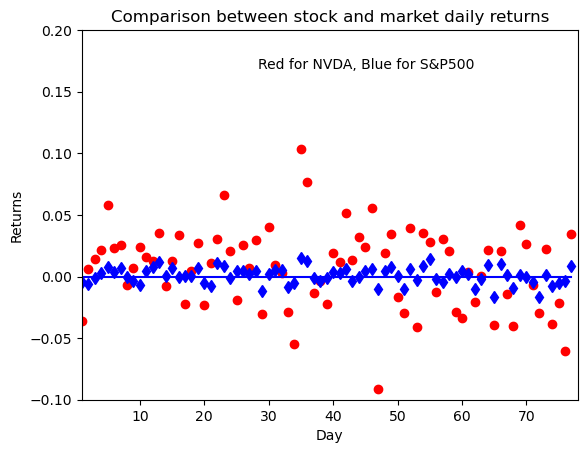

In [4]:
# example 2
def ret_f(ticker, begdate, enddate):
    data = yf.download(ticker, start=begdate, end=enddate, group_by='ticker')
    return data['Open'].pct_change(1)

begdate = dt.date(2024,1,1)
enddate = dt.date.today().strftime('%Y-%m-%d')

ret1 = ret_f('NVDA',begdate, enddate)
ret2 = ret_f('^GSPC',begdate, enddate)
n = min(len(ret1), len(ret2))
t = range(n)
line = np.zeros(n)
plt.plot(t, ret1[0:n], 'ro')
plt.plot(t, ret2[0:n], 'bd')
plt.plot(t, line, 'b')
plt.figtext(0.4, 0.8, "Red for NVDA, Blue for S&P500")
plt.xlim(1,n)
plt.ylim(-0.10, 0.20)
plt.title("Comparison between stock and market daily returns")
plt.xlabel("Day")
plt.ylabel("Returns")
plt.show()

In [5]:
# example 3
start_date = dt.date(2024,4,1)
end_date = dt.datetime.today().strftime('%Y-%m-%d')

all_data = {}
for ticker in ['AAPL','IBM','MSFT','GOOG']:
    all_data[ticker] = yf.download(ticker, start_date, end_date)

price = pd.DataFrame({symbol: data['Close'] for symbol, data in all_data.items()})
volume = pd.DataFrame({symbol: data['Volume'] for symbol, data in all_data.items()})
returns = price.pct_change()
print(returns.tail())
print(returns.corr())
pd.options.display.float_format='{:,.6f}'.format
print(returns.cov())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                AAPL       IBM      MSFT      GOOG
Date                                              
2024-04-17 -0.008147 -0.003537 -0.006609  0.005641
2024-04-18 -0.005714 -0.008902 -0.018381  0.003697
2024-04-19 -0.012213  0.000606 -0.012739 -0.011050
2024-04-22  0.005091  0.001762  0.004610  0.014321
2024-04-23  0.006392  0.001594  0.016485  0.012472
          AAPL       IBM      MSFT      GOOG
AAPL  1.000000  0.021374  0.548164  0.567268
IBM   0.021374  1.000000  0.525106  0.495654
MSFT  0.548164  0.525106  1.000000  0.675348
GOOG  0.567268  0.495654  0.675348  1.000000
         AAPL      IBM     MSFT     GOOG
AAPL 0.000228 0.000003 0.000094 0.000115
IBM  0.000003 0.000089 0.000057 0.000063
MSFT 0.000094 0.000057 0.000130 0.000103
GOOG 0.000115 0.000063 0.000103 0.000180


## connect python sqlite3 to database

In [20]:
# create and populate tables 
import sqlite3

connection = sqlite3.connect('MarketData.db')
cursor = connection.cursor()

# Symbols
cursor.execute("Drop table if exists Symbols; ")

sql_command = """
Create Table if not exists Symbols (
Symbol text Primary Key Not Null,
CUSIP text Not Null, 
CompanyName text Not Null
); 
"""

cursor.execute(sql_command)

cursor.executemany("Insert into Symbols(Symbol, CUSIP, CompanyName) Values(?, ?, ?)",
    [
    ("GOOG", "38259P508", "Alphabet Inc."),
    ("IBM", "459200101", "International Business Machines Corporation."),
    ("C", "312072001", "Citigroup.")
    ]
)


In [21]:
# Traders
cursor.execute("Drop table if exists Traders;")

sql_command = """
Create Table if not exists Traders (
TraderID text Primary Key Not Null,
LastName text Not Null,
FirstName text Not Null,
Email text Not Null,
Phone text Not Null
);
"""
cursor.execute(sql_command)

cursor.executemany("Insert into Traders Values(?, ?, ?, ?, ?)",
    [
    ("1234", "ABC", "Joe", "JA123@gs.com", "212-111-1234"),
    ("1245", "BCD", "Andy", "AB123@jp.com", "212-222-1234"),
    ("2345", "ABC", "Smith", "SA234@citi.com", "212-333-1234")
    ]
)

In [22]:
# Orders
cursor.execute("Drop table if exists Orders;")

sql_command = """
Create Table if not exists Orders (
OrderID text Primary Key Not Null,
Price real ,
Quantity integer Not Null,
Side char(1) Not Null,
OrderType text Not Null,
Symbol text Not Null,
Foreign Key(Symbol) references Symbols(Symbol)
);
"""
cursor.execute(sql_command)

cursor.executemany("Insert into Orders Values(?, ?, ?, ?, ?, ?)",
    [
    ("GSJA000111122015", "717.01", "200", "B", "Limit", "GOOG"),
    ("JPAB000111132015", "", "125", "S", "Market", "GOOG"),
    ("CTSA000111132015", "131.75", "1000", "B", "Limit", "IBM"),
    ("GSJA000211122015", "53.17", "10000", "B", "Limit", "C"),
    ("JPAB000211132015", "131.70", "2000", "S", "Limit", "IBM"),
    ("CTSA000211132015", "", "200", "B", "Market", "C")
    ]
)

In [23]:
# Executions
cursor.execute("Drop table if exists Executions;")

sql_command = """
Create Table if not exists Executions (
ExecutionsID text Not Null,
Status char(1) Not Null,
Exchange char(1) Not Null,
FreeText text ,
OrderID text Not Null,
TraderID text Not Null,
PRIMARY KEY(ExecutionsID, TraderID),
Foreign Key(OrderID) references Orders(OrderID),
Foreign Key(TraderID) references Traders(TraderID)
);
"""
cursor.execute(sql_command)

cursor.executemany("insert into Executions Values(?, ?, ?, ?, ?, ?)",
    [
    ("123", "6", "P", "Partial Filled", "GSJA000111122015", "1234"),
    ("124", "8", "P", "Filled", "JPAB000111132015", "1245"),
    ("125", "0", "N", "Pending", "CTSA000111132015", "2345"),
    ("126", "4", "P", "Cancelled", "GSJA000211122015", "1234"),
    ("127", "0", "N", "Pending", "JPAB000211132015", "1245"),
    ("128", "8", "N", "Filled", "CTSA000211132015", "2345")
    ]
)

connection.commit()
connection.close()

In [24]:
import sqlite3
connection = sqlite3.connect("MarketData.db")
cursor = connection.cursor()
cursor.execute(" SELECT Symbols.*, Traders.*, Orders.*, Executions.* \
               FROM Traders INNER JOIN (Symbols INNER JOIN (Orders INNER JOIN \
               Executions ON Orders.OrderID = Executions.OrderID) \
               ON Symbols.Symbol = Orders.Symbol) ON \
               Traders.[TraderID]=Executions.TraderID ;")

result = cursor.fetchall()
for r in result:
    print(r)

('GOOG', '38259P508', 'Alphabet Inc.', '1234', 'ABC', 'Joe', 'JA123@gs.com', '212-111-1234', 'GSJA000111122015', 717.01, 200, 'B', 'Limit', 'GOOG', '123', '6', 'P', 'Partial Filled', 'GSJA000111122015', '1234')
('GOOG', '38259P508', 'Alphabet Inc.', '1245', 'BCD', 'Andy', 'AB123@jp.com', '212-222-1234', 'JPAB000111132015', '', 125, 'S', 'Market', 'GOOG', '124', '8', 'P', 'Filled', 'JPAB000111132015', '1245')
('IBM', '459200101', 'International Business Machines Corporation.', '2345', 'ABC', 'Smith', 'SA234@citi.com', '212-333-1234', 'CTSA000111132015', 131.75, 1000, 'B', 'Limit', 'IBM', '125', '0', 'N', 'Pending', 'CTSA000111132015', '2345')
('C', '312072001', 'Citigroup.', '1234', 'ABC', 'Joe', 'JA123@gs.com', '212-111-1234', 'GSJA000211122015', 53.17, 10000, 'B', 'Limit', 'C', '126', '4', 'P', 'Cancelled', 'GSJA000211122015', '1234')
('IBM', '459200101', 'International Business Machines Corporation.', '1245', 'BCD', 'Andy', 'AB123@jp.com', '212-222-1234', 'JPAB000211132015', 131.7, 2